https://github.com/partytax/ncei-api-guide

In [29]:
import pandas as pd
import xarray as xr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, progress

In [30]:
# Sets up a local cluster on keeling and a tmp directory for dask processes
dask.config.set(temporary_directory='/data/keeling/a/leanneb2/tmp/leanneb2-dask/')  
client = Client()  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 503.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37781,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 503.48 GiB
Comm: tcp://127.0.0.1:36372,Total threads: 5
Dashboard: http://127.0.0.1:36801/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:39570,


In [31]:
# Make garbage collection explicit to prevent deadlocks
import gc
from distributed import WorkerPlugin

class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()             

    def transition(self, key, start, finish, *args, **kwargs):
       if finish == 'executing':
          self.worker._throttled_gc.collect()
          if gc.isenabled():
             gc.disable()

plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:34047': {'status': 'OK'},
 'tcp://127.0.0.1:36372': {'status': 'OK'},
 'tcp://127.0.0.1:37995': {'status': 'OK'},
 'tcp://127.0.0.1:38419': {'status': 'OK'},
 'tcp://127.0.0.1:40049': {'status': 'OK'},
 'tcp://127.0.0.1:43382': {'status': 'OK'},
 'tcp://127.0.0.1:46002': {'status': 'OK'},
 'tcp://127.0.0.1:46169': {'status': 'OK'}}

1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. 

In [15]:
# This builds a file list of ERA5 monthly mean SST files and accumulated precipitation
# from 1979-2021 (files are for every year but contain monthly means)
base_url_sst = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url_precip = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2_sst = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url2_precip = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# Pandas fuction that creates an array of date time objects with an annual frequency
# during the period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_sst=[]
file_list_precip = []
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Builds complete file name and appends it to a list of files that need to
    # be downloaded for each variable
    single_file_sst = (base_url_sst+year+base_url2_sst+month+'_'+month2+base_url3)
    file_list_sst.append(single_file_sst)

    single_file_precip = (base_url_precip+year+base_url2_precip+month+'_'+month2+base_url3)
    file_list_precip.append(single_file_precip)

In [16]:
len(file_list_sst)

43

In [17]:
len(file_list_precip)

43

In [18]:
# Defines Pacific Ocean latitude and longitude grid
pacific_north_lat = 65.0
pacific_south_lat = -65.0
pacific_east_lon = 120.0
pacific_west_lon = 300.0

# Creates an xarray dataset for the sst and precip variables
ds_sst = xr.open_mfdataset(file_list_sst, parallel=True, chunks={'time': '50MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
ds_precip = xr.open_mfdataset(file_list_precip, parallel=True, chunks={'time': '50MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

# # Extract the long term mean over the 1981-2010 period.
# ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])
# mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()

# mean_1981_2010.compute()

In [22]:
ds_precip.TP

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Total precipitation
    short_name:                    tp
    units:                         m
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               228
    minimum_value:                 0.0
    maximum_value:                 0.11752701
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface fore...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [6]:
ds_sst.SSTK

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Sea surface temperature
    short_name:                    sstk
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               34
    minimum_value:                 269.3069
    maximum_value:                 306.40942
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface anal...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [23]:
# # Computing the monthly mean ssts at every latitude and longitude box
# monthly_mean_sst = ds_sst.SSTK.groupby('time.month').mean()
# ds_sst.SSTK.groupby('time.month')

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [24]:
# Computes the monthly mean SST anomalies at each latitude and longitude box for 
# each year
monthly_mean_sst_ano = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time')
monthly_mean_precip_ano = ds_precip.TP.groupby('time.month') - ds_precip.TP.groupby('time.month').mean(dim='time')

In [25]:
#https://foundations.projectpythia.org/core/xarray/computation-masking.html
monthly_mean_sst_ano

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [26]:
monthly_mean_precip_ano

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


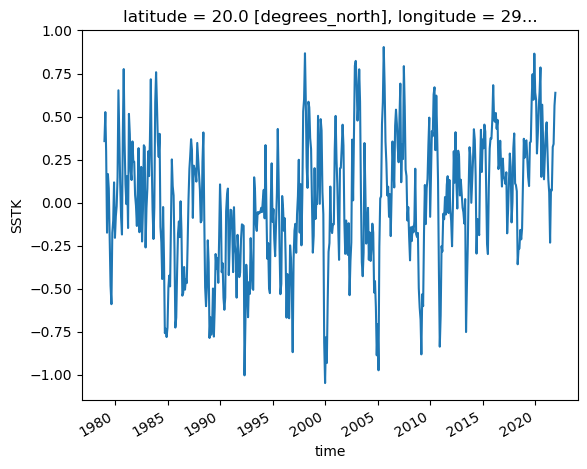

In [27]:
monthly_mean_sst_ano.sel(longitude=290, latitude=20, method='nearest').plot()

/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


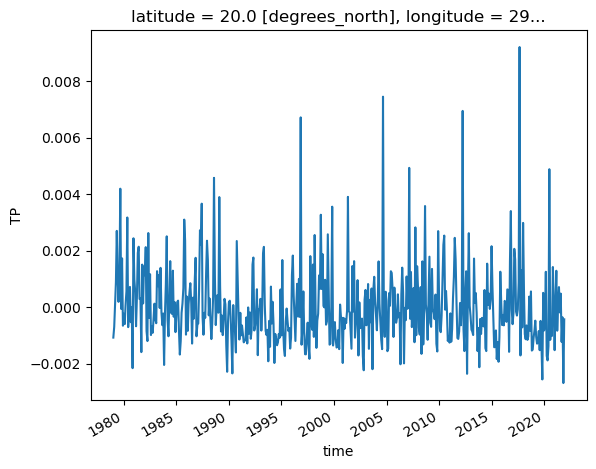

In [28]:
monthly_mean_precip_ano.sel(longitude=290, latitude=20, method='nearest').plot()

In [ ]:
client.close()

In [98]:
# Getting the file that we want to mask our SST data with, selecting out the Pacific 
# domain we want
land_sea_mask = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')
pacific_domain_lsm = land_sea_mask['LSM'].sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
#pacific_domain_lsm = land_sea_mask.sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

In [100]:
# Dropping the time dimension from the LSM datarray, adding a new time dimension
# to it so the LSM dataarray is the same size as the SST dataarray, and masking
# the SST dataarray where there is land
lsm_dropped_time = pacific_domain_lsm.squeeze('time')
sst_times = pd.date_range(start='1979-01-01',end='2021-12-31', freq='MS')
lsm_all_times = lsm_dropped_time.expand_dims(dim={"time": ds_sst.time})
lsm_all_times
# masked_sst = ds_sst.where(lsm_all_times == 1, np.nan)
masked_sst = np.ma.masked_where(lsm_all_times == 1, ds_sst.SSTK)